# Pet's Faces Dataset

Используем упрощенный датасет с вырезанными лицами домашних животных.

In [4]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np


Для визуализации списка изображений можно использовать такую функцию:

In [5]:
def display_images(l, titles=None,fontsize=50, bs = 5):
    n = min(bs, 5)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        if i == n:
          break
        ax[i].imshow(im)
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i],fontsize=fontsize)
    fig.set_size_inches(fig.get_size_inches() * n)
    plt.tight_layout()
    plt.show()


In [6]:
gpu_available = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(gpu_available))

Num GPUs: 0


In [8]:
batch_size = 5
img_size = (128, 128)

data_gen_aug = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255., validation_split = 0.2, rotation_range = 30, horizontal_flip = True, zoom_range = 0.2, brightness_range = [0.5, 1])
data_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255., validation_split=0.2)

train_data = data_gen_aug.flow_from_directory("D:\petfaces", batch_size = batch_size, target_size = img_size,  subset = "training", seed = 20, class_mode = 'categorical', shuffle = True)
test_data = data_gen.flow_from_directory("D:\petfaces", batch_size = batch_size, target_size = img_size, subset = "validation", seed = 20, class_mode = 'categorical', shuffle = False)


Found 2583 images belonging to 35 classes.
Found 628 images belonging to 35 classes.


In [9]:
lablesNames = ['cat_Abyssinian', 'cat_Bengal', 'cat_Birman', 'cat_Bombay', 
               'cat_British', 'cat_Egyptian', 'cat_Maine', 'cat_Persian', 
               'cat_Ragdoll', 'cat_Russian', 'cat_Siamese', 'cat_Sphynx',
               'dog_american', 'dog_basset', 'dog_beagle', 'dog_boxer', 
               'dog_chihuahua', 'dog_english', 'dog_german', 'dog_great', 
               'dog_havanese', 'dog_japanese', 'dog_keeshond', 'dog_leonberger', 
               'dog_miniature', 'dog_newfoundland', 'dog_pomeranian', 'dog_pug', 
               'dog_saint', 'dog_samoyed', 'dog_scottish', 'dog_shiba', 
               'dog_staffordshire', 'dog_wheaten', 'dog_yorkshire']

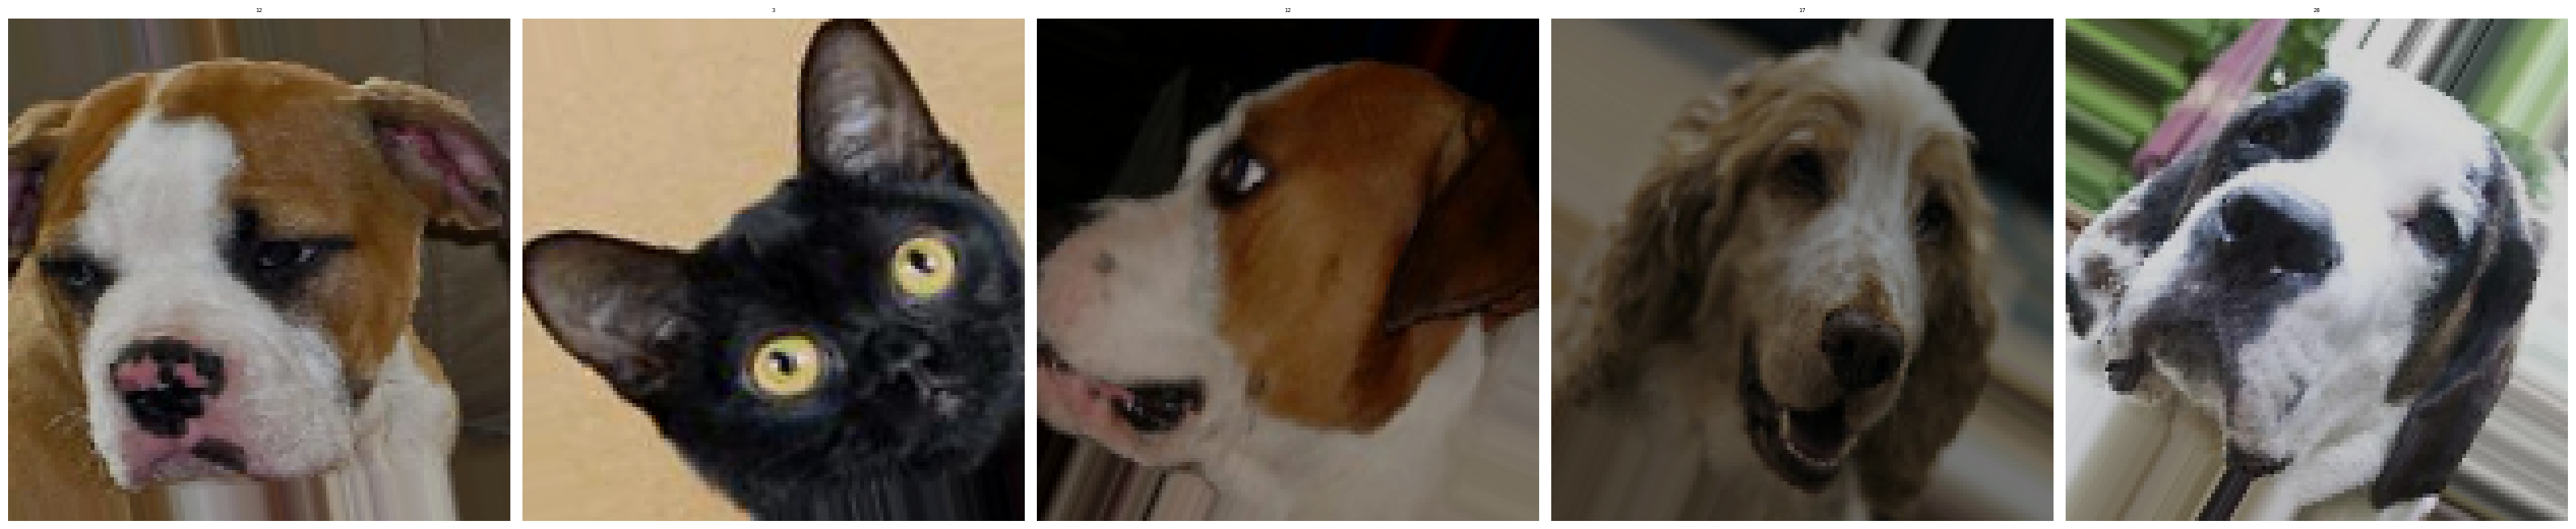

In [10]:
display_images(train_data[0][0], np.argmax(train_data[0][1], axis = 1), batch_size)

In [11]:
from keras.layers import *

model = keras.models.Sequential()

model.add(Conv2D(32, (15, 15), input_shape=(128, 128, 3), activation='tanh'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (5, 5), activation='tanh'))
model.add(MaxPooling2D())
model.add(Dense(128,  activation="relu"))
model.add(Dense(128,  activation="tanh"))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(1024,  activation="tanh"))
model.add(Dense(1024,  activation="tanh"))
model.add(Dense(512,  activation="tanh"))
model.add(Dense(512,  activation="tanh"))
model.add(Dense(35, activation='softmax'))

model.compile(tf.keras.optimizers.Adam(0.0001), 'categorical_crossentropy', ['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(3)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 114, 114, 32)      21632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 57, 57, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 53, 53, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 26, 26, 64)       0         
 2D)                                                             
                                                                 
 dense (Dense)               (None, 26, 26, 128)       8320      
                                                                 
 dense_1 (Dense)             (None, 26, 26, 128)       1

In [12]:
hits = model.fit(train_data, validation_data = test_data, epochs = 15)

Epoch 1/15
517/517 [==============================] - 247s 473ms/step - loss: 3.3559 - accuracy: 0.0914 - top_k_categorical_accuracy: 0.2137 - val_loss: 2.8848 - val_accuracy: 0.1799 - val_top_k_categorical_accuracy: 0.3965
Epoch 2/15
517/517 [==============================] - 236s 457ms/step - loss: 2.7466 - accuracy: 0.2203 - top_k_categorical_accuracy: 0.4433 - val_loss: 2.3247 - val_accuracy: 0.2978 - val_top_k_categorical_accuracy: 0.5828
Epoch 3/15
517/517 [==============================] - 235s 455ms/step - loss: 2.3300 - accuracy: 0.3124 - top_k_categorical_accuracy: 0.5726 - val_loss: 2.1109 - val_accuracy: 0.3838 - val_top_k_categorical_accuracy: 0.6274
Epoch 4/15
517/517 [==============================] - 236s 457ms/step - loss: 2.0773 - accuracy: 0.3933 - top_k_categorical_accuracy: 0.6431 - val_loss: 1.9316 - val_accuracy: 0.4379 - val_top_k_categorical_accuracy: 0.6879
Epoch 5/15
517/517 [==============================] - 237s 458ms/step - loss: 1.8567 - accuracy: 0.4533 

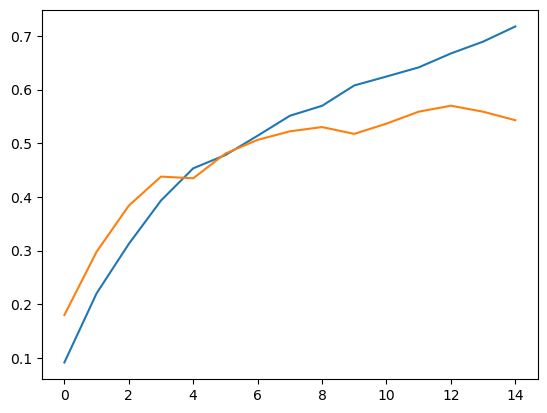

In [13]:
plt.plot(hits.history['accuracy'])
plt.plot(hits.history['val_accuracy'])
None

126/126 [==============================] - 6s 44ms/step


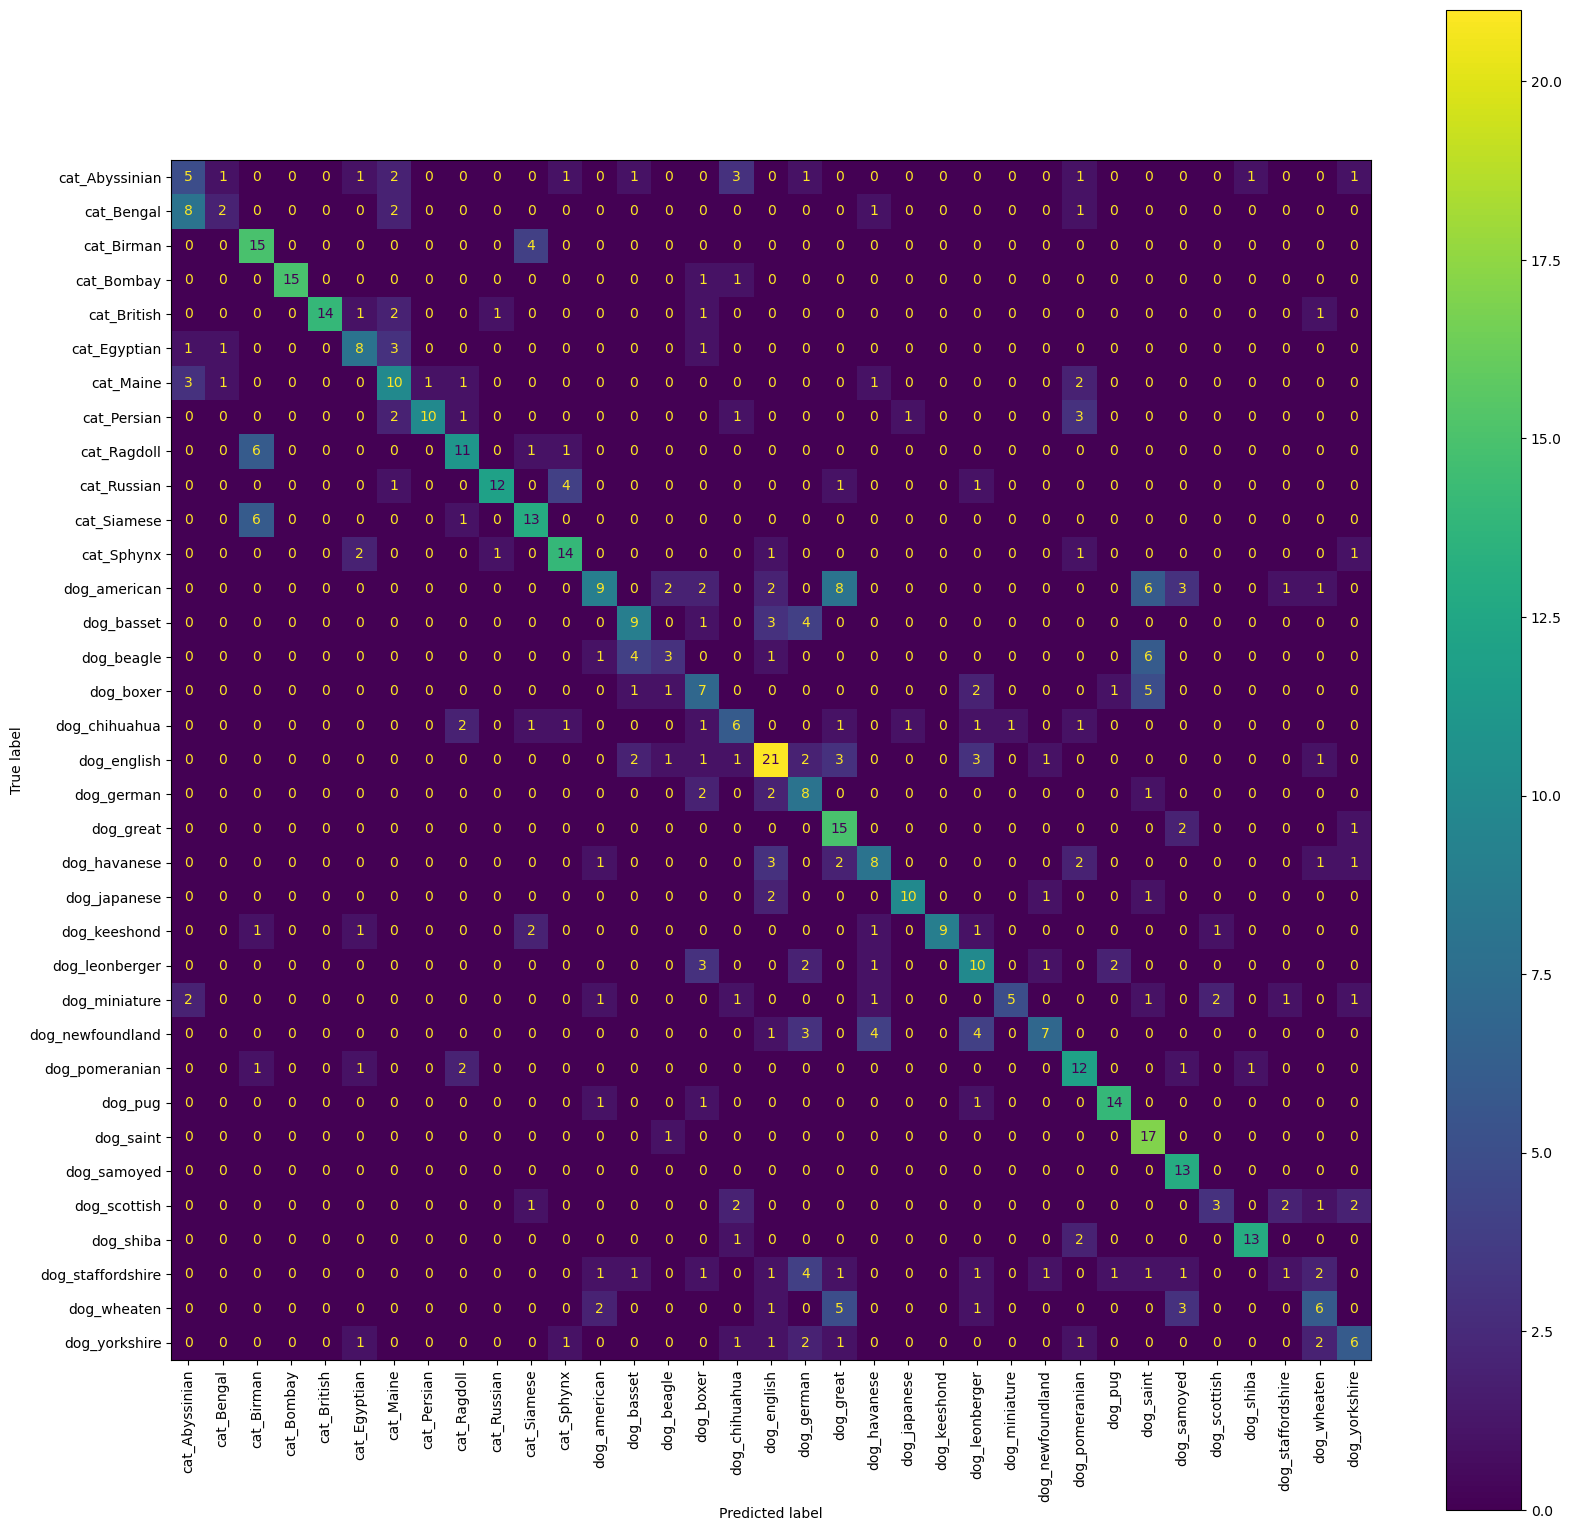

In [14]:
n_batches = len(test_data)

test_labels = np.concatenate([np.argmax(test_data[i][1], axis = 1) for i in range(n_batches)])    
predictions = np.argmax(model.predict(test_data, steps = n_batches), axis=1) 

cm = confusion_matrix(test_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                               display_labels = lablesNames)

fig = plt.figure(figsize = (10, 10))
ax = fig.add_axes([0, 0, 1.5, 1.5])

disp.plot(ax = ax, xticks_rotation='vertical')
plt.show()

Точность для классификации "Кошка-собака"

In [15]:
r = 0

test_labels = np.concatenate([np.argmax(test_data[i][1], axis = 1) for i in range(n_batches)])    
predictions = np.argmax(model.predict(test_data, steps = n_batches), axis=1) 

for i in range(len(test_labels)):
  if (test_labels[i] <= 12 and predictions[i] <= 12) or (test_labels[i] > 12 and predictions[i] > 12):
      r += 1

print("acc = {}".format( r / len(test_labels)))

r = 0

predictions = model.predict(test_data, steps = n_batches) 
indexes = np.argsort(-predictions, axis = 1)

for i in range(len(predictions)):
  if (((indexes[i][0] <= 12 or indexes[i][1] <= 12 or indexes[i][2] <= 12) and (test_labels[i] <=12)) or (indexes[i][0] > 12 or indexes[i][1] > 12 or indexes[i][2] > 12) and (test_labels[i] > 12)):
    r += 1;

print("top 3 acc = {}".format( r / len(test_labels)))


126/126 [==============================] - 6s 44ms/step
acc = 0.8773885350318471
126/126 [==============================] - 6s 48ms/step
top 3 acc = 0.964968152866242
